In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt

import io

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor

from ipywidgets import interact, FloatSlider

In [2]:
import os
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('matplotlibrc')

In [3]:
grid_dir = 'rhoPupGrid'
tracks = []
for file in os.listdir(grid_dir):
    tracks += [pd.read_table(os.path.join(grid_dir, file), sep='\s+')]

In [4]:
y_columns = ['age', 'log_Teff', 'log_L']
X_columns = ['M', 'Y', 'Z', 'alpha_MLT']

In [5]:
Xs = []
ys = [] 

for track in tracks:
    Xs += [[track.M.values[0], 
            track.Y.values[0],
            track.Z.values[0],
            track.alpha.values[0]]]
    ys += [np.hstack((track.age.values, 
                      track.log_L.values, 
                      track.log_Teff.values))]

Xs = np.array(Xs)
ys = np.array(ys)

In [6]:
ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(20, 20), 
                                  max_iter=20000, activation='relu', solver='lbfgs', tol=1e-9))]),
         transformer=RobustScaler())

ml.fit(Xs, ys)

TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler', RobustScaler()),
                                                     ('mlp',
                                                      MLPRegressor(hidden_layer_sizes=(20,
                                                                                       20),
                                                                   max_iter=20000,
                                                                   solver='lbfgs',
                                                                   tol=1e-09))]),
                           transformer=RobustScaler())

In [7]:
pred = ml.predict([Xs[0]])[0]
ages = pred[:len(track.age.values)]
log_Ls = pred[len(track.age.values):len(track.age.values)*2]
log_Teffs = pred[2*len(track.age.values):]

In [8]:
def plot_HR(M, Y, Z, alpha_MLT):
    pred = ml.predict([[M, Y, Z, alpha_MLT]])[0]
    ages = pred[:len(track.age.values)]
    log_Ls = pred[len(track.age.values):len(track.age.values)*2]
    log_Teffs = pred[2*len(track.age.values):]
    
    log_Ls = sp.interpolate.UnivariateSpline(range(len(log_Ls)), log_Ls, s=0.000001, k=2)(range(len(log_Ls)))
    log_Teffs = sp.interpolate.UnivariateSpline(range(len(log_Teffs)), log_Teffs, s=0.000001, k=2)(range(len(log_Teffs)))
    
    plt.figure(figsize=(8,6))

    plt.plot(log_Teffs[1:], log_Ls[1:], '-', lw=2)

    plt.gca().invert_xaxis()
    plt.xlabel(r'$\log\;T_{\rm{eff}}/\rm{K}$')
    plt.ylabel(r'$\log\;L/\rm{L}_\odot$')

    plt.grid()
    plt.show()

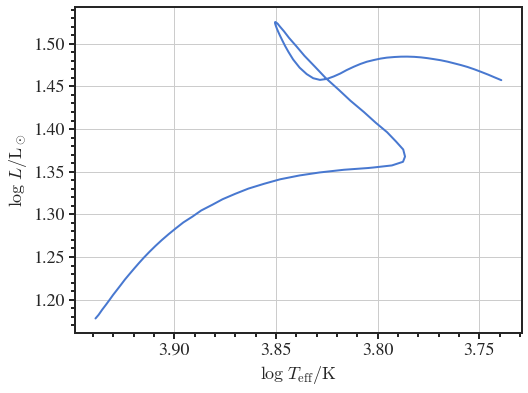

In [9]:
plot_HR(*Xs.mean(axis=0))

In [10]:
interact(plot_HR, 
         M=FloatSlider(min=Xs.min(axis=0)[0],         max=Xs.max(axis=0)[0], step=0.01,   value=Xs.mean(axis=0)[0], 
                       continuous_update=True),
         Y=FloatSlider(min=Xs.min(axis=0)[1],         max=Xs.max(axis=0)[1], step=0.001,  value=Xs.mean(axis=0)[1], 
                       continuous_update=True),
         Z=FloatSlider(min=Xs.min(axis=0)[2],         max=Xs.max(axis=0)[2], step=0.0005, value=Xs.mean(axis=0)[2], 
                       continuous_update=True),
         alpha_MLT=FloatSlider(min=Xs.min(axis=0)[3], max=Xs.max(axis=0)[3], step=0.01,   value=Xs.mean(axis=0)[3], 
                       continuous_update=True),
        );

interactive(children=(FloatSlider(value=2.0011742440944893, description='M', max=2.197791, min=1.804041, step=…